# Setting

In [1]:
outdir = './output'

import os
if not os.path.isdir(outdir):
    os.mkdir(outdir)
    pass

In [2]:
datadir = '/data/ms2840a'
#filename = '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_2'
#filename = '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtLargeBB'
filename = '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal'
filenames = [ f'{filename}_{i}.dat' for i in range(100) ]
labels = [ f'{i}' for i in range(100) ]
freq_min = 4 # [GHz]
freq_max = 12 # [GHz]
legendON = False
csvType = 'TwoColumn'; # freq, dBm

'''
datadir = '/Users/shadachi/Experiment/DOSUE/data/ms2840a/2022-02-01/data'
filenames = [
'Yfactor300K_sweep_KyotoMS2840A_1.dat',
'Yfactor300K_sweep_TohokuMS2840A_1.dat'
]
labels = [
    'Kyoto SpeAna', 
    'Tohoku SpeAna'
]
freq_min = 15. # [GHz]
freq_max = 28 # [GHz]
csvType = 'TwoColumn'; # freq, dBm
'''

# csv type examples:
# csvType = 'TwoColumn'; # freq, dBm
# csvType = 'Anritsu'; # Anritsu Spectrum analyzer: Waveform output
# csvType = 'Keysight'; # Keysight Spectrum Analyzer USB: output
# csvType = 'OneColumn'; # dBm 
# csvType = 'TwoColumn'; # freq, dBm

# default average binning
nFreqAve = 10 

# constant
k_B = 1.380649e-23  # boltzmann const. [J/K]

In [3]:
print(filenames)
print(labels)

['2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_0.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_1.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_2.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_3.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_4.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_5.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_6.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_7.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_8.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_9.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_10.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_11.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_12.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_13.dat', '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal_14.dat', '2022-08-26/data/DOSUE-Y_test_AllA

# Import libraries

In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt
# set colorful lines
cmap = plt.get_cmap('jet')

# Define function to read csv datafile

In [5]:
# start_freq, stop_freq, npoints are only used in OneColumn type
def read_csv(filename, csvType='Anritsu', start_freq=None, stop_freq=None, npoints=None):
    
    freq = [] # frequency list [GHz]
    power = [] # power list  [mW]
    
    f = open(filename, 'r');
    if csvType=='TwoColumn':
        fin = list( csv.reader(f, delimiter=' ') )
    else:
        fin = list(csv.reader(f))
    #print(fin)  #リストの中身を出力
    isData = False
    
    if csvType=='Anritsu': # Anritsu : NOTE: only for RMS detection
        
        start_freq = 0
        stop_freq = 0
        npoints = 0
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            # Search for frequency range
            if first == 'Trace-A':
                start_freq = int(line[1])
                stop_freq  = int(line[2])
                continue
            # Search for npoints
            if first == 'RMS':
                npoints = int(line[1])
                continue
            # Search for data starting point (Anritsu: Wave Data)
            if first.startswith('Wave Data'):
                isData = True
                continue
            # Get data
            if isData:
                power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
                pass
            pass
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
            
    elif csvType=='Keysight' : # Keysight
        
        for line in fin:
            if len(line)==0 : continue
            # Search for data starting point (Keysight: DATA)
            #print(f'first = {first}')
            if first == 'DATA':
                isData = True
                continue
            isData = True # All lines are data
            # Get data
            if isData:
                freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
                power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
                pass
            pass
        
    elif csvType=='TwoColumn' : # Hz, dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
            power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
            pass
        
    elif csvType=='OneColumn' : # dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
            pass
        if (start_freq is None) or (stop_freq is None) or (npoints is None):
            print('Error! There is no arguments for frequency information (start_freq, stop_freq, npoints).')
            print('Error! Please specify them!')
            return None
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
        
        pass
    
    return np.array(freq), np.array(power)
                

# Define funcition to calculate frequency average

In [6]:
def freq_average(data, naverage=100):

    ndata = len(data)
    npoints = int(ndata/naverage)
    
    data_ave = []
    data_err = []
    
    for i in range(npoints):
        data_subset = data[i*naverage:(i+1)*naverage]
        average = np.mean(data_subset)
        average_err = np.std(data_subset)/np.sqrt(naverage) #  = 1/N * sqrt( sum((y-mean)^2))  ( std = sqrt( sum((y-mean)^2) / N) )
        data_ave.append(average)
        data_err.append(average_err)
        pass
    
    return np.array(data_ave), np.array(data_err)

# Define function to interpolate spectrum over frequency

In [7]:
# interp_kind = 'linear': linear interpolation
# interp_kind = 'cubic' : splineinterpolation
from scipy import interpolate
def freq_interpolate(freq, freq1, power1, interp_kind='cubic'):
    interp_func = interpolate.interp1d(freq1, power1, kind=interp_kind)
    return interp_func(freq)

# Read csv data

In [8]:
freqs_array = []
powers_array = []
for filename in filenames:
    _freq, _power = read_csv(f'{datadir}/{filename}', csvType)
    
    # Select data between freq_min and freq_max
    _power = _power[_freq<=freq_max]
    _freq = _freq[_freq<=freq_max]
    _power = _power[_freq>=freq_min]
    _freq = _freq[_freq>=freq_min]
    
    freqs_array.append(_freq)
    powers_array.append(_power)
    pass

freqs_array = np.array(freqs_array)
powers_array = np.array(powers_array)

In [9]:
print(freqs_array)
print(powers_array)
print(freqs_array)
print(powers_array)

[[ 4.     4.001  4.002 ... 11.998 11.999 12.   ]
 [ 4.     4.001  4.002 ... 11.998 11.999 12.   ]
 [ 4.     4.001  4.002 ... 11.998 11.999 12.   ]
 ...
 [ 4.     4.001  4.002 ... 11.998 11.999 12.   ]
 [ 4.     4.001  4.002 ... 11.998 11.999 12.   ]
 [ 4.     4.001  4.002 ... 11.998 11.999 12.   ]]
[[1.50244912e-07 1.25689680e-07 1.35300797e-07 ... 6.26758261e-08
  7.65419793e-08 9.03025305e-08]
 [1.65424451e-07 1.32342790e-07 1.28943551e-07 ... 8.26417884e-08
  7.74461689e-08 7.41480339e-08]
 [1.11301145e-07 1.55131420e-07 1.32403717e-07 ... 7.33330905e-08
  8.01862745e-08 7.02587287e-08]
 ...
 [1.27643809e-07 1.77337220e-07 1.45077389e-07 ... 7.89950344e-08
  6.54787396e-08 7.87589185e-08]
 [1.15080055e-07 1.43482878e-07 1.44810539e-07 ... 8.26417884e-08
  9.33253645e-08 5.78628812e-08]
 [1.57652092e-07 1.20809174e-07 1.12331026e-07 ... 9.20873190e-08
  9.11171374e-08 7.83249812e-08]]
[[ 4.     4.001  4.002 ... 11.998 11.999 12.   ]
 [ 4.     4.001  4.002 ... 11.998 11.999 12.   ]
 [

###  Plot Power [mW]

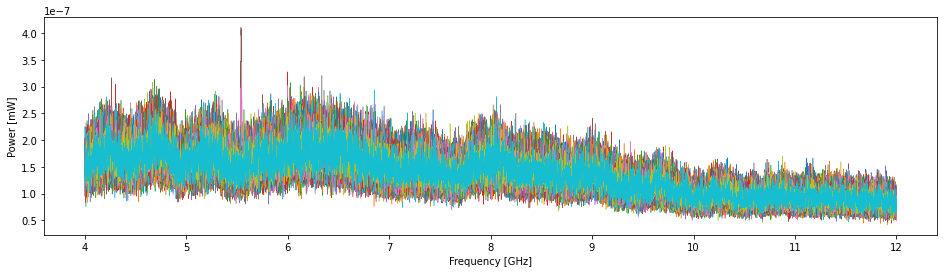

In [10]:
fig = plt.figure(figsize=(16,4))
for i, filename in enumerate(filenames):
    plt.plot(freqs_array[i], powers_array[i], label=f'{i}', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    pass
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

if legendON: plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power_mW.png')
plt.show()

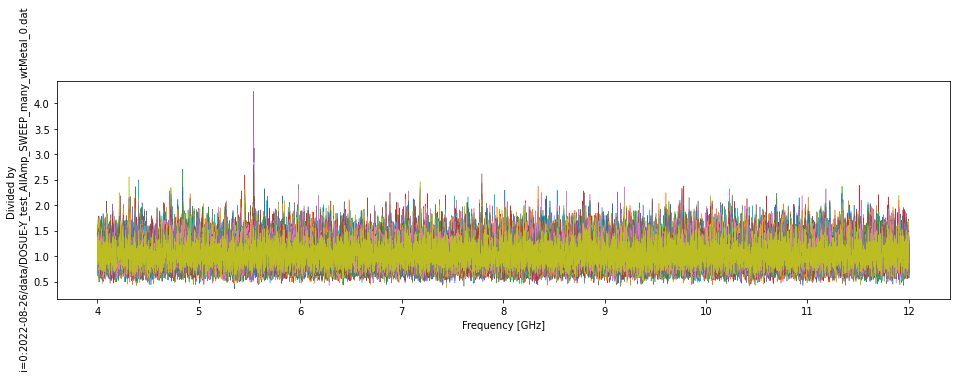

In [11]:
freq0 = freqs_array[0]
power0 = powers_array[0]
fig = plt.figure(figsize=(16,4))
plt.plot(freq0, np.full(len(freq0), 1.), color='k', linewidth=0.5, linestyle='-')
for i, filename in enumerate(filenames):
    if i==0: continue
    power_interp = freq_interpolate(freq0, freqs_array[i], powers_array[i])
    div_power =power_interp/power0
    plt.plot(freq0, div_power, label=f'{i}', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'Divided by \n i=0:{filenames[0]}') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

if legendON: plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power_div.png')
plt.show()

###  Plot Power [dBm]

power > -65 dB: 15 @ [5.539] GHz
power > -65 dB: 25 @ [4.261] GHz
power > -65 dB: 35 @ [6.162] GHz
power > -65 dB: 63 @ [6.] GHz
power > -65 dB: 87 @ [6.337] GHz


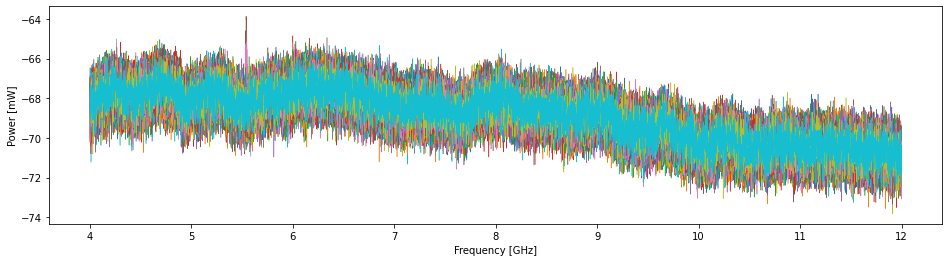

In [12]:
fig = plt.figure(figsize=(16,4))
for i, filename in enumerate(filenames):
    power_dBm = np.log10(powers_array[i])*10.
    plt.plot(freqs_array[i], power_dBm, label=f'{i}', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    #cutdBm = -60
    cutdBm = -65
    if max(power_dBm)>cutdBm: 
        print(f'power > {cutdBm} dB: {i} @ {freqs_array[i][power_dBm==np.max(power_dBm)]} GHz')
        pass
    pass
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

if legendON: plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power_dBm.png')
plt.show()

### Plot averaged power

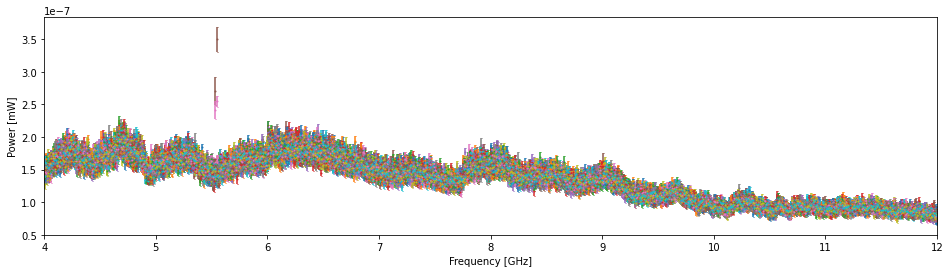

In [13]:
## Averaging
freqs_ave_array = []
powers_ave_array = []
powers_ave_err_array = []
for i, filename in enumerate(filenames):
    _freq_ave, tmp = freq_average(freqs_array[i], naverage=nFreqAve)
    _power_ave, _power_ave_err = freq_average(powers_array[i], naverage=nFreqAve)
    freqs_ave_array.append(_freq_ave)
    powers_ave_array.append(_power_ave)
    powers_ave_err_array.append(_power_ave_err)
    pass
freqs_ave_array = np.array( freqs_ave_array )
powers_ave_array = np.array( powers_ave_array )
powers_ave_err_array = np.array( powers_ave_err_array )

## Plotting
fig = plt.figure(figsize=(16,4))
for i, filename in enumerate(filenames):
    plt.errorbar(freqs_ave_array[i], powers_ave_array[i], yerr=powers_ave_err_array[i], 
                 label=f'{i}', capsize=0.5, fmt='o', markersize=1, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                )
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(0,0.006) #y軸範囲指定
if legendON: plt.legend()

plt.savefig(f"{outdir}/compare_multiple_power_average.png")
plt.show()

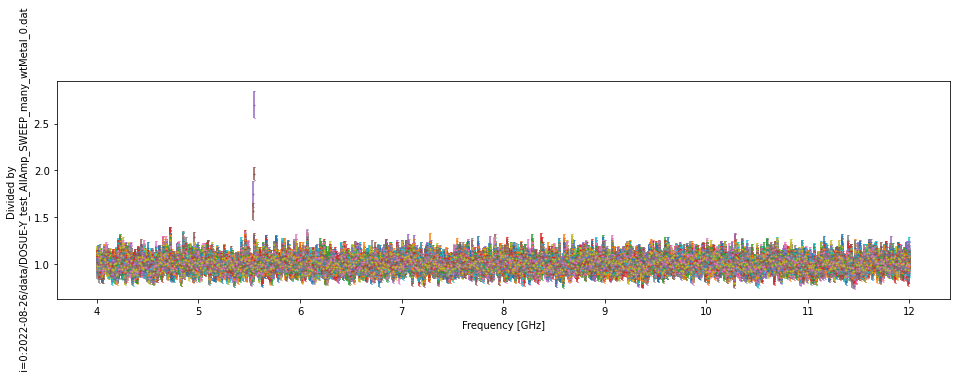

In [14]:
freq0 = freqs_ave_array[0]
power0 = powers_ave_array[0]
fig = plt.figure(figsize=(16,4))
plt.plot(freq0, np.full(len(freq0), 1.), color='k', linewidth=0.5, linestyle='-')
for i, filename in enumerate(filenames):
    if i==0: continue
    power_interp = freq_interpolate(freq0, freqs_ave_array[i], powers_ave_array[i])
    power_err_interp = freq_interpolate(freq0, freqs_ave_array[i], powers_ave_err_array[i])
    div_power = power_interp/power0
    div_power_err = power_err_interp/power0
    plt.errorbar(freq0, div_power, yerr=div_power_err, 
                 label=f'{i}', capsize=0.5, fmt='o', markersize=1, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                )
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'Divided by \n i=0:{filenames[0]}') #y軸の名前
if legendON: plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power-ave_div.png')
plt.show()